# <center> Innoscape - Telecom Paristech - Projet fil rouge </center>
# <center> Mapping Groupes de produits </center>

In [1]:
# Librairies 
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

import re
import random
from Preprocessing2 import *
from gensim import models, corpora

from ²n import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

#chemin = "../Data/"
chemin = "C:/Users/JN/Desktop/Telecom ParisTech/Cours/fil_rouge/github/Data/"
chemin_val = "/Users/valentinphetchanpheng/Documents/MS BGD Telecom ParisTech/Projet Fil Rouge/"

C:\Users\JN\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import xgboost as xgb
#import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

## Création d'un dataset étiqueté unique

Importation du dataset intégral:

In [7]:
# Importation des données vendeurs
df_seller = pd.read_csv(chemin + 'df_total_clean.csv', sep = ",").fillna('')
df_seller.drop("Unnamed: 0",axis=1,inplace=True)
df_seller.head()

productfamily_seller prodcategory4_seller              prodcategory3_seller  \
0   Colles à carrelage   Colles à carrelage                Colles et adhésifs   
1                                                                               
2                                            Accessoires pour lave vaisselles   
3               Mastic               Mastic                Colles et adhésifs   
4                Cires                Cires   Peintures teintures et solvants   

                      prodcategory2_seller prodcategory1_seller  \
0                            Quincaillerie            Bricolage   
1                                                                 
2                              Accessoires  Gros électroménager   
3                            Quincaillerie            Bricolage   
4  Peintures outils et traitement des murs            Bricolage   

                                  productseller_name  \
0  SikaCeram Xtra   Colle à carrelage intérieur e...   
1   Ariston 3200362 scaldabagno elettrico PRO 100 H3   
2  AEG Panier À Couverts Lave vaisselle Cage & Ha...   
3              Colle mastic pour joints d étanchéité   
4  Sikagard Protection Sol MAT   Imperméabilisant...   

  productfamily_seller_clean prodcategory4_seller_clean  \
0            colle carrelage            colle carrelage   
1                                                         
2                                                         
3                     mastic                     mastic   
4                       cire                       cire   

  prodcategory3_seller_clean     prodcategory2_seller_clean  \
0              colle adhesif                  quincaillerie   
1                                                             
2  vaisselle accessoire lave                     accessoire   
3              colle adhesif                  quincaillerie   
4  teinture peinture solvant  peinture outil traitement mur   

  prodcategory1_seller_clean  \
0                  bricolage   
1                              
2        electromenager gros   
3                  bricolage   
4                  bricolage   

                            productseller_name_clean  
0  max blanc exterieur carreau xtra interieur col...  
1                    scaldabagno heure pro elettrico  
2  couvercle laver vaisselle compartiment panier ...  
3                      etancheite mastic colle joint  
4           mat sol impermeabiliser effet protection

Importation des données étiquetées

In [45]:
labels = pd.read_excel(chemin+"df_train-4.xlsx").set_index('Index')
labels['Product_family_innoscape'] = labels['Product_family_innoscape'].str.strip().str.lower()
#labels_clean = preprocessing(labels, ['Product_family_innoscape'], dico1, dico2, stop_words, "C:/TreeTagger")

In [46]:
labels.head()

Product_category_1_innoscape Product_category_2_innoscape  \
Index                                                             
0          Matériaux et Menuiserie   Colles-Adhésifs-Etanchéité   
28         Matériaux et Menuiserie   Colles-Adhésifs-Etanchéité   
49         Matériaux et Menuiserie   Colles-Adhésifs-Etanchéité   
63         Matériaux et Menuiserie   Colles-Adhésifs-Etanchéité   
3          Matériaux et Menuiserie   Colles-Adhésifs-Etanchéité   

        Product_family_innoscape  A dégager  
Index                                        
0      mastic, colle, étanchéité        NaN  
28     mastic, colle, étanchéité        NaN  
49     mastic, colle, étanchéité        NaN  
63     mastic, colle, étanchéité        NaN  
3      mastic, colle, étanchéité        NaN

Importation des données étiquetées sur la base des indices de Jaccard

In [47]:
df_jaccard = pd.read_csv(chemin+'20190115-mapping_jaccard.csv')
df_jaccard.set_index("Unnamed: 0", inplace=True)
df_jaccard['best_match'] = df_jaccard['best_match'].str.strip().str.lower()
df_jaccard.head()

productfamily_seller  \
Unnamed: 0                        
6             Perceuse-visseuse   
25          Marteau perforateur   
38                 Taille-haies   
59                      Bobines   
60               Pulvérisateurs   

                                           productseller_name id_source  \
Unnamed: 0                                                                
6           Perceuse-visseuse RYOBI 18V OnePlus - 1 batter...    AMZ_FR   
25          AEG Powertools Marteau Perforateur BBH 18 (PRO...    AMZ_FR   
38           Ryobi 5133002113 RHT36C5525 Taille-haie sans fil    AMZ_FR   
59          lot therm filme 3 bobines + fil 1,6mm pour gam...    AMZ_FR   
60          Ryobi - OWS1880 One - Pulvérisateur pour déshe...    AMZ_FR   

            max_sim_prod_fam  max_occurences_prod_fam  \
Unnamed: 0                                              
6                        0.5                        1   
25                       0.5                        1   
38                       1.0                        1   
59                       0.0                      105   
60                       1.0                        1   

                                  best_match_prod_fam  \
Unnamed: 0                                              
6           Perceuse, perforateur et visseuse filaire   
25                                            Marteau   
38                                       Taille-haies   
59                                           no match   
60                                      Pulvérisation   

                                       ex_aequos_prod_fam  \
Unnamed: 0                                                  
6           ['Perceuse, perforateur et visseuse filaire']   
25                                            ['Marteau']   
38                                       ['Taille-haies']   
59                                           ['no match']   
60                                      ['Pulvérisation']   

                          prod_fam                             cat4  \
Unnamed: 0                                                            
6           {'perceux', 'visseux'}                      {'perceux'}   
25           {'perfor', 'marteau'}                      {'perceux'}   
38                {'taill', 'hai'}                 {'taill', 'hai'}   
59                       {'bobin'}  {'bordur', 'accessoir', 'coup'}   
60                    {'pulveris'}                     {'pulveris'}   

                                                         cat3  \
Unnamed: 0                                                      
6                                 {'outillag', 'electroport'}   
25                                {'outillag', 'electroport'}   
38                          {'outillag', 'motoris', 'jardin'}   
59                        {'outillag', 'accessoir', 'jardin'}   
60          {'protect', 'contr', 'le', 'lutt', 'nuisibl', ...   

                                                    cat2          cat1  \
Unnamed: 0                                                               
6                    {'main', 'outillag', 'electroport'}  {'bricolag'}   
25                   {'main', 'outillag', 'electroport'}  {'bricolag'}   
38          {'outillag', 'motoris', 'tondeux', 'jardin'}    {'jardin'}   
59          {'outillag', 'motoris', 'tondeux', 'jardin'}    {'jardin'}   
60                                          {'jardinag'}    {'jardin'}   

                                                  description  \
Unnamed: 0                                                      
6           {'batter', 'oneplus', 'perceux', 'rcd', 'visse...   
25          {'bbh', 'powertool', 'perfor', 'marteau', 'ion...   
38             {'san', 'ryob', 'taill', 'fil', 'rhtc', 'hai'}   
59          {'ryob', 'rac', 'fil', 'therm', 'film', 'lot',...   
60          {'vert', 'pulveris', 'ryob', 'desherbag', 'one...   

            max_sim_description  max_occurences_description  \
Unnamed: 0         

Comparaison des labels entre les deux parties du dataset étiqueté

In [54]:
labels_manuels = sorted(labels.Product_family_innoscape.unique())

In [88]:
labels_manuels

['abris de jardin',
 "accessoires amenagement et produits d'entretien",
 'accessoires chauffe-eau',
 'accessoires couverture',
 "accessoires d'isolation",
 'accessoires du tableau électrique (bornier, peigne,etc)',
 'accessoires et consommables outillage électroportatif',
 'accessoires et divers outils peintre',
 'accessoires gros oeuvre',
 'accessoires outillage stationnaire',
 'accessoires plein air',
 'accessoires pour electroménager-four-hotte-réfrigérateur-plaque de cuisson',
 'accessoires pour nettoyeur haute pression',
 'accessoires pour outillage motorisé',
 'accessoires pour outillage à main de jardin',
 'adoucisseur',
 'ampoules et leds',
 'aménagements décoratifs',
 'anti-mousse',
 'arrosage',
 'aspirateurs, nettoyeurs hp et accessoires',
 'aspirateurs, souffleurs, broyeurs',
 'aérateur et vmc',
 'barbecue',
 'bardage',
 'barre de seuil et nez de marche',
 'batterie et chargeur',
 'brise-vue, canisse, brande, grillage et brise vent',
 'carré potager et table de rempotage',
 

In [89]:
labels_jaccard = sorted(df_jaccard.best_match.unique())

In [90]:
labels_jaccard

['accessoires chauffe-eau',
 'accessoires couverture',
 "accessoires d'isolation",
 'accessoires et consommables outillage électroportatif',
 'accessoires et divers outils peintre',
 'accessoires gros oeuvre',
 'accessoires outillage stationnaire',
 'accessoires pour nettoyeur haute pression',
 'accessoires pour outillage à main de jardin',
 'ampoules et leds',
 'anti-mousse',
 'arrosage',
 'aspirateurs, souffleurs, broyeurs',
 'aérateur et vmc',
 'barbecue',
 'bardage',
 'barre de seuil et nez de marche',
 'batterie et chargeur',
 'brise-vue, canisse, brande et brise vent',
 'carré potager et table de rempotage',
 'charpente',
 'chaudière',
 'chauffe-eau gaz',
 'chauffe-eau thermodynamique',
 'chauffe-eau électrique',
 'clé et douille',
 'compresseurs et accessoires',
 "conduit et accessoires d'aération",
 'couverture',
 'disjoncteur, coupe-circuit et interrupteur différentiel',
 'divers',
 'débroussailleuse et coupe-bordures',
 'défonceuse et lamelleuse et rabot',
 'fixation, pipe et

In [58]:
diff1 = [x for x in labels_manuels if x not in labels_jaccard]
diff2 = [y for y in labels_jaccard if y not in labels_manuels]

In [59]:
print(len(diff1))
print(len(diff2))

38
4


Commentaire: sans surprise, la quasi-totalité des labels du dataset Jaccard sont dans le dataset labellisé à la main ; voyons d'où viennent les différences:

In [60]:
diff2

['brise-vue, canisse, brande et brise vent',
 'chaudière',
 'mastic colle etanchéité',
 'visserie-clouterie']

On va donc modifier ces intitulés pour avoir des labels cohérents sur tout le dataset étiqueté:

In [91]:
df_jaccard['best_match'] = df_jaccard['best_match'].str.replace('brise-vue, canisse, brande et brise vent','brise-vue, canisse, brande, grillage et brise vent')
df_jaccard['best_match'] = df_jaccard['best_match'].str.replace('chaudière','chauffage')
df_jaccard['best_match'] = df_jaccard['best_match'].str.replace('mastic colle etanchéité', 'mastic, colle, étanchéité')
# on garde l'intitulé de la dernière famille tel quel, car il s'agit d'une famille très peu représentée 
#qui n'a pas été incluse dans le dataset labellisé à la main

Enfin, on n'intègre au datset labellisé que les lignes LM pré-labellisées avec un indice de Jaccard suffisamment élevé pour éviter les erreurs d'attribution:

In [92]:
df_jaccard2 = df_jaccard[df_jaccard['similarity']>0.5]

On peut à présent regrouper toutes les données labellisées dans un seul dataset.

In [166]:
#ajout des labels obtenus à la main au dataset complet:
df2 = df_seller.copy()
df2 = df2.merge(labels, how='inner',left_index=True,right_index=True)
cols_to_keep = list(df_seller.columns)+['Product_family_innoscape']
df2 = df2[cols_to_keep]

#ajout des labels obtenus par Jaccard au dataset complet
df3 = df_seller.copy()
duplicate_cols = list(set(df_seller.columns).intersection(set(df_jaccard2.columns)))
df_jaccard3 = df_jaccard2.drop(duplicate_cols, axis=1)
df3 = df3.merge(df_jaccard3, how='inner',left_index=True,right_index=True)
cols_to_keep2 = list(df_seller.columns)+['best_match']
df3 = df3[cols_to_keep2]
df3.rename(columns={'best_match':'Product_family_innoscape'}, inplace=True)

#concaténation des deux dataframes en un seul:
df_train_all = pd.concat([df2,df3],axis=0)

#suppression des doublons
df_train_all.drop_duplicates(inplace=True)
dup_idx = df_train_all.index.get_duplicates()
df_train_all.drop(dup_idx, axis=0, inplace=True)

C:\Users\JN\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead


In [167]:
df_train_all.shape

(6650, 14)

In [168]:
len(sorted(df_train_all['Product_family_innoscape'].unique()))

97

In [169]:
#sauvegarde du dataset
df_train_all.to_csv('20190403_df_train_all.csv', index=True)

In [5]:
#chargement du dataset
df_train_all = pd.read_csv('20190403_df_train_all.csv', index_col=0)
df_train_all.head()

productfamily_seller   prodcategory4_seller  \
0     Colles à carrelage     Colles à carrelage   
3                 Mastic                 Mastic   
4                  Cires                  Cires   
6      Perceuse visseuse              Perceuses   
7  Produits d étanchéité  Produits d étanchéité   

              prodcategory3_seller                     prodcategory2_seller  \
0               Colles et adhésifs                            Quincaillerie   
3               Colles et adhésifs                            Quincaillerie   
4  Peintures teintures et solvants  Peintures outils et traitement des murs   
6        Outillage électroportatif      Outillage à main et électroportatif   
7               Colles et adhésifs                            Quincaillerie   

  prodcategory1_seller                                 productseller_name  \
0            Bricolage  SikaCeram Xtra   Colle à carrelage intérieur e...   
3            Bricolage              Colle mastic pour joints d étanchéité   
4            Bricolage  Sikagard Protection Sol MAT   Imperméabilisant...   
6            Bricolage  Perceuse visseuse RYOBI 18V OnePlus   1 batter...   
7            Bricolage  Sika Multiseal   Bande d étanchéité autocollan...   

  productfamily_seller_clean prodcategory4_seller_clean  \
0            colle carrelage            colle carrelage   
3                     mastic                     mastic   
4                       cire                       cire   
6   perceur visseur|visseuse                    perceur   
7         etancheite produit         etancheite produit   

  prodcategory3_seller_clean      prodcategory2_seller_clean  \
0              colle adhesif                   quincaillerie   
3              colle adhesif                   quincaillerie   
4  teinture peinture solvant   peinture outil traitement mur   
6  outillage electroportatif  outillage electroportatif main   
7              colle adhesif                   quincaillerie   

  prodcategory1_seller_clean  \
0                  bricolage   
3                  bricolage   
4                  bricolage   
6                  bricolage   
7                  bricolage   

                            productseller_name_clean  \
0  max blanc exterieur carreau xtra interieur col...   
3                      etancheite mastic colle joint   
4           mat sol impermeabiliser effet protection   
6  oneplus visseur|visseuse lithium perceur batte...   
7  etancheite dechirure cuit terre bander autocol...   

                                              concat  \
0  colle carrelage colle carrelage colle adhesif ...   
3  mastic mastic colle adhesif quincaillerie bric...   
4  cire cire teinture peinture solvant peinture o...   
6  perceur visseur|visseuse perceur outillage ele...   
7  etancheite produit etancheite produit colle ad...   

                     Product_family_innoscape  
0                   mastic, colle, étanchéité  
3                   mastic, colle, étanchéité  
4                   mastic, colle, étanchéité  
6  perceuse, perforateur et visseuse sans fil  
7                   mastic, colle, étanchéité

## Etude de l'influence du paramètre "max features" lors de la transformation en tf-idf:

On commence par regrouper toutes les données textuelles dans une seule colonne de texte:

In [8]:
df_train_all['concat'] = df_train_all['productfamily_seller_clean'] + ' ' + \
                     df_train_all['prodcategory4_seller_clean'] + ' ' + \
                     df_train_all['prodcategory3_seller_clean'] + ' ' + \
                     df_train_all['prodcategory2_seller_clean'] + ' ' + \
                     df_train_all['prodcategory1_seller_clean'] + ' ' + \
                     df_train_all['productseller_name_clean']

On retire ensuite les familles dont les effectifs sont trop faibles pour entraîner un classifieur:

In [9]:
fam_counts = df_train_all.groupby('Product_family_innoscape').count()['productfamily_seller']
main_fams = list(fam_counts[fam_counts>20].index.values)
df_train_main_fams = df_train_all[df_train_all['Product_family_innoscape'].isin(main_fams)]

On effectue un tf-idf sur l'ensemble du corpus:

In [10]:
df_seller['concat'] = df_seller['productfamily_seller_clean'] + ' ' + \
                     df_seller['prodcategory4_seller_clean'] + ' ' + \
                     df_seller['prodcategory3_seller_clean'] + ' ' + \
                     df_seller['prodcategory2_seller_clean'] + ' ' + \
                     df_seller['prodcategory1_seller_clean'] + ' ' + \
                     df_seller['productseller_name_clean']

Wall time: 0 ns


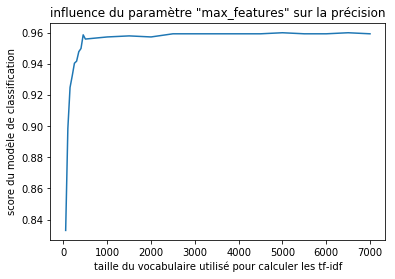

In [145]:
n_top_words = list(np.arange(50,550,50))+list(np.arange(500,7500,500))
scores = []

%time
for element in n_top_words:
    #calcul des tf-idf
    vectorizer = TfidfVectorizer(max_features = element)
    tf_idf_total = sparse.csr_matrix(vectorizer.fit_transform(df_seller["concat"]))
    
    #constitution d'un train set et d'un test set:
    X = pd.DataFrame(tf_idf_total.todense()).set_index(df_seller.index.values).loc[df_train_main_fams.index]
    
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2, random_state = 548)
    
    #entraînement d'un classifieur sur le train set et calcul du score
    etc = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
    etc.fit(Xtrain,Ytrain)
    scores.append(etc.score(Xtest,Ytest))
    

#affichage des résultats:
chart = plt.plot(n_top_words, scores)
plt.xlabel('taille du vocabulaire utilisé pour calculer les tf-idf')
plt.ylabel('score du modèle de classification')
plt.title('influence du paramètre "max_features" sur la précision')
plt.show()

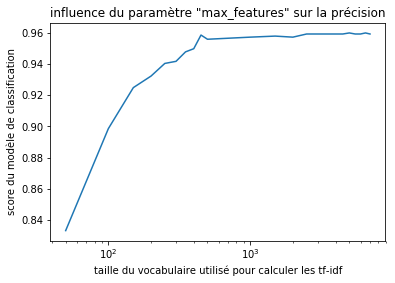

In [146]:
fig, ax = plt.subplots()
ax.set_xscale('log')
chart2 = plt.plot(n_top_words, scores)
plt.xlabel('taille du vocabulaire utilisé pour calculer les tf-idf')
plt.ylabel('score du modèle de classification')
plt.title('influence du paramètre "max_features" sur la précision')
plt.show()

## Embedding - NMF 200

On reprend la totalité du corpus existant:

In [122]:
num_top_words = 500
vectorizer = TfidfVectorizer(max_features = num_top_words)
tf_idf_total = sparse.csr_matrix(vectorizer.fit_transform(df_seller["concat"]))
vectorizer.get_feature_names()

['abergement',
 'about',
 'accessoire',
 'acier',
 'acrylique',
 'adherence',
 'adhesif',
 'adjuver',
 'aerateur',
 'aeration',
 'aerosol',
 'air',
 'alde',
 'alimentation',
 'alu',
 'aluminium',
 'amarante',
 'ancien',
 'angle',
 'angulaire',
 'anthracite',
 'anti',
 'ardoise',
 'ardoiser',
 'aretier',
 'arret',
 'arrosage',
 'aspirateur',
 'atelier',
 'atlantique',
 'auto',
 'autocollant',
 'autoporte',
 'autre',
 'avoir',
 'bain',
 'ballon',
 'bande',
 'bandeau',
 'bander',
 'bardage',
 'bardelis',
 'barre',
 'batiment',
 'batterie',
 'bavette',
 'beige',
 'beton',
 'bidon',
 'blanc',
 'bois',
 'boite',
 'bordure',
 'bourgogne',
 'bourrelet',
 'bpe',
 'branche',
 'brande',
 'brico',
 'bricolage',
 'briser',
 'broyeur',
 'brun',
 'burineur',
 'cacher',
 'canal',
 'canisse',
 'carrelage',
 'cartouche',
 'castelviel',
 'chaine',
 'champagne',
 'chapeau',
 'charentais',
 'chargeur',
 'charpente',
 'chatiere',
 'chaud',
 'chauffage',
 'chauffe',
 'chaux',
 'chene',
 'chevreuse',
 'chimie

In [ ]:
nmf = NMF(n_components=200, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tf_idf_total)

In [12]:
from sklearn.externals import joblib

#joblib.dump(nmf, "nmf_200topics_20190403.save") 
nmf = joblib.load("nmf_200topics_20190403.save") 

In [55]:
X = pd.DataFrame(nmf.transform(tf_idf_total.todense())).set_index(df_seller.index.values).loc[df_train_main_fams.index]
X.rename(columns=dict(zip(range(200),['topic_'+str(i) for i in range(200)])),inplace=True)
Y = df_train_main_fams['Product_family_innoscape']
df_topics = df_train_main_fams.merge(X, how='inner', left_index=True, right_index=True)
df_topics['Product_family_innoscape'] = Y
df_topics[['productfamily_seller','productseller_name','Product_family_innoscape']].head()

productfamily_seller                                 productseller_name  \
0     Colles à carrelage  SikaCeram Xtra   Colle à carrelage intérieur e...   
3                 Mastic              Colle mastic pour joints d étanchéité   
4                  Cires  Sikagard Protection Sol MAT   Imperméabilisant...   
6      Perceuse visseuse  Perceuse visseuse RYOBI 18V OnePlus   1 batter...   
7  Produits d étanchéité  Sika Multiseal   Bande d étanchéité autocollan...   

                     Product_family_innoscape  
0                   mastic, colle, étanchéité  
3                   mastic, colle, étanchéité  
4                   mastic, colle, étanchéité  
6  perceuse, perforateur et visseuse sans fil  
7                   mastic, colle, étanchéité

### Etude des top topics par famille

On peut à présent étudier la distribution des poids des top topics sur le dataset.Voyons d'abord comment se répartit la somme des poids des produits sur l'échantillon:

C:\Users\JN\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


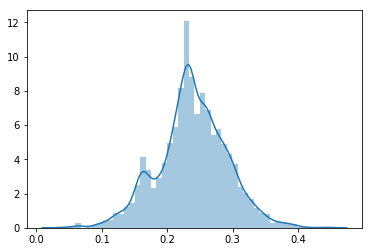

In [56]:
col_names = ['topic_'+str(i) for i in range(200)]
weights = df_topics[col_names]
total_weights = np.sum(weights, axis=1)
chart = sns.distplot(total_weights)

df_topics['total_weights'] = total_weights

On remarque que la NMF ne semble pas effectuer de normalisation des poids (ie mettre le total des coefficients à 1). Qui plus est, on observe qu'une petite minorité de produits a des poids extrêment faibles sur tous les topics, et ne sont donc pas correctement décrits par l'embedding retenu. On va donc normaliser les poids des topics.

On définit ensuite quelques fonctions pour identifier les principaux topics associés à un produit et leurs coefficients:

In [14]:
def get_top_topics(row, num_topics, num_top_topics):
    cols_to_fetch = ['topic_'+str(i) for i in range(num_topics)]
    top_topics_idx = np.argsort(-np.array(row[cols_to_fetch]))[:num_top_topics]
    top_topics_cols = ['topic_'+str(i) for i in top_topics_idx]
    top_topics_weights = row[top_topics_cols].values
    return [top_topics_idx,top_topics_weights]

In [39]:
def unpack_top_topics(df, top_topics_col,total_weights_col ,num_top_topics):
    col_names1 = ['top_topic_'+str(i) for i in range(1,num_top_topics+1)]
    col_names2 = ['top_topic_'+str(i)+'_relative_weight' for i in range(1,num_top_topics+1)]
    df2 = df.copy()
    for i in range(len(col_names1)):
        df2[col_names1[i]] = df[top_topics_col].apply(lambda x: x[0][i])
        df2[col_names2[i]] = df[top_topics_col].apply(lambda x: x[1][i])
        df2[col_names2[i]] = df2[col_names2[i]]/df2[total_weights_col]
    return df2

In [57]:
num_topics = 200
num_top_topics = 4
df_topics['top_top'] = df_topics.apply(get_top_topics, args=([200,num_top_topics]), axis=1)
df_topics = unpack_top_topics(df_topics,'top_top','total_weights', num_top_topics)
df_topics.drop('top_top', axis=1, inplace=True)
df_topics.head()

productfamily_seller   prodcategory4_seller  \
0     Colles à carrelage     Colles à carrelage   
3                 Mastic                 Mastic   
4                  Cires                  Cires   
6      Perceuse visseuse              Perceuses   
7  Produits d étanchéité  Produits d étanchéité   

              prodcategory3_seller                     prodcategory2_seller  \
0               Colles et adhésifs                            Quincaillerie   
3               Colles et adhésifs                            Quincaillerie   
4  Peintures teintures et solvants  Peintures outils et traitement des murs   
6        Outillage électroportatif      Outillage à main et électroportatif   
7               Colles et adhésifs                            Quincaillerie   

  prodcategory1_seller                                 productseller_name  \
0            Bricolage  SikaCeram Xtra   Colle à carrelage intérieur e...   
3            Bricolage              Colle mastic pour joints d étanchéité   
4            Bricolage  Sikagard Protection Sol MAT   Imperméabilisant...   
6            Bricolage  Perceuse visseuse RYOBI 18V OnePlus   1 batter...   
7            Bricolage  Sika Multiseal   Bande d étanchéité autocollan...   

  productfamily_seller_clean prodcategory4_seller_clean  \
0            colle carrelage            colle carrelage   
3                     mastic                     mastic   
4                       cire                       cire   
6   perceur visseur|visseuse                    perceur   
7         etancheite produit         etancheite produit   

  prodcategory3_seller_clean      prodcategory2_seller_clean  \
0              colle adhesif                   quincaillerie   
3              colle adhesif                   quincaillerie   
4  teinture peinture solvant   peinture outil traitement mur   
6  outillage electroportatif  outillage electroportatif main   
7              colle adhesif                   quincaillerie   

  prodcategory1_seller_clean  \
0                  bricolage   
3                  bricolage   
4                  bricolage   
6                  bricolage   
7                  bricolage   

                            productseller_name_clean  \
0  max blanc exterieur carreau xtra interieur col...   
3                      etancheite mastic colle joint   
4           mat sol impermeabiliser effet protection   
6  oneplus visseur|visseuse lithium perceur batte...   
7  etancheite dechirure cuit terre bander autocol...   

                                              concat  \
0  colle carrelage colle carrelage colle adhesif ...   
3  mastic mastic colle adhesif quincaillerie bric...   
4  cire cire teinture peinture solvant peinture o...   
6  perceur visseur|visseuse perceur outillage ele...   
7  etancheite produit etancheite produit colle ad...   

                     Product_family_innoscape  topic_0  topic_1   topic_2  \
0                   mastic, colle, étanchéité      0.0      0.0  0.005047   
3                   mastic, colle, étanchéité      0.0      0.0  0.005440   
4                   mastic, colle, étanchéité      0.0      0.0  0.000000   
6  perceuse, perforateur et visseuse sans fil      0.0      0.0  0.008217   
7                   mastic, colle, étanchéité      0.0      0.0  0.006219   

   topic_3   topic_4  topic_5  topic_6  topic_7  topic_8   topic_9  topic_10  \
0      0.0  0.000000      0.0      0.0      0.0      0.0  0.000000       0.0   
3      0.0  0.005141      0.0      0.0      0.0      0.0  0.000000       0.0   
4      0.0  0.032532      0.0      0.0      0.0      0.0  0.040656       0.0   
6      0.0  0.000000      0.0      0.0      0.0      0.0  0.000000       0.0   
7      0.0  0.001678      0.0      0.0      0.0      0.0  0.000002       0.0   

   topic_11  topic_12  topic_13  topic_14  topic_15  \
0  0.000000       0.0  0.022231       0.0       0.0   
3  0.025521       0.0  0.000000       0.0       0.0   
4  0.000000       0.0  0.000000       0.0  

Pour déterminer combien de topics permettent en moyenne de caractériser un produit, voyons à présent la distribution moyenne des poids des principaux topics: 

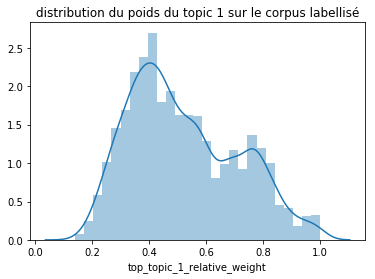

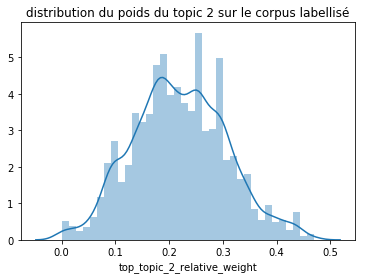

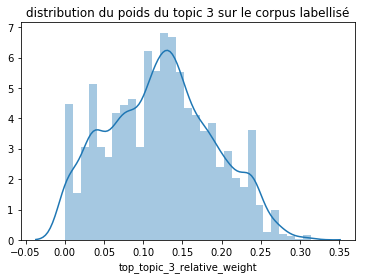

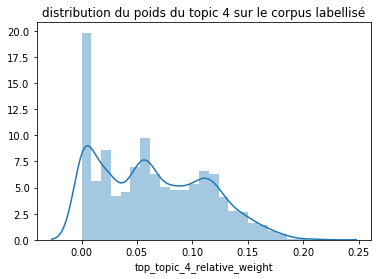

In [58]:
for i in range(num_top_topics) :
    sns.distplot(df_topics['top_topic_'+str(i+1)+'_relative_weight'])
    plt.title('distribution du poids du topic '+str(i+1)+' sur le corpus labellisé')
    plt.show()

On voit ainsi qu'une majorité de produits peut être caractérisée par les deux premiers topics, représentant généralement près de 60% du poids des topics. Voyons à présent, pour chaque famille de produits, quels sont les topics qui reviennent le plus souvent dans les deux 1ers topics:

In [60]:
df_topics.columns[:30]

Index(['productfamily_seller', 'prodcategory4_seller', 'prodcategory3_seller',
       'prodcategory2_seller', 'prodcategory1_seller', 'productseller_name',
       'productfamily_seller_clean', 'prodcategory4_seller_clean',
       'prodcategory3_seller_clean', 'prodcategory2_seller_clean',
       'prodcategory1_seller_clean', 'productseller_name_clean', 'concat',
       'Product_family_innoscape', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9',
       'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15'],
      dtype='object')

In [378]:
topics_by_fam = df_topics.groupby('Product_family_innoscape').sum()
topics_by_fam = topics_by_fam[col_names]
total_weights = np.sum(topics_by_fam, axis=1)
topics_by_fam['total_weights'] = total_weights
topics_by_fam['top_top'] = topics_by_fam.apply(get_top_topics, args=([200,3]), axis=1)
topics_by_fam = unpack_top_topics(topics_by_fam,'top_top','total_weights', 3)

topics_by_fam[['top_topic_1','top_topic_1_relative_weight','top_topic_2','top_topic_2_relative_weight']].head(50)

top_topic_1  \
Product_family_innoscape                                          
accessoires chauffe-eau                                      12   
accessoires couverture                                       95   
accessoires et consommables outillage électropo...           57   
accessoires pour nettoyeur haute pression                    39   
accessoires pour outillage motorisé                          39   
ampoules et leds                                            175   
aménagements décoratifs                                      72   
anti-mousse                                                 154   
arrosage                                                    193   
aspirateurs, souffleurs, broyeurs                           103   
aérateur et vmc                                              91   
bardage                                                       4   
barre de seuil et nez de marche                              59   
batterie et chargeur                                         17   
brise-vue, canisse, brande, grillage et brise vent           58   
chauffage                                                   129   
chauffe-eau gaz                                             121   
chauffe-eau électrique                                       12   
conduit et accessoires d'aération                            20   
contenants                                                  169   
couverture                                                   14   
disjoncteur, coupe-circuit et interrupteur diff...          180   
divers                                                      134   
divers oep                                                  187   
débroussailleuse et coupe-bordures                           52   
défonceuse et lamelleuse et rabot                           148   
gouttière, descente et accessoires                            8   
grillage avertisseur et gaine de protection                   5   
mastic, colle, étanchéité                                    13   
meuleuse et rainureuse                                       32   
motobineuses et motoculteurs                                170   
mousse expansive                                            154   
outil motorisé modulable                                     39   
outillage à main                                             22   
outils multifonctions                                        37   
peinture                                                      6   
perceuse, perforateur et visseuse filaire                    27   
perceuse, perforateur et visseuse sans fil                   10   
pince et tenaille                                           184   
pistolet à colle et agrafeuse                               182   
plinthe bois, plinthe mdf, plinthe pvc                       28   
ponceuse électrique                                          33   
poudre béton, chaux, ciment, enduit, mortier, r...          136   
protection jardin, paillage, tuteurs et accesso...           63   
scies électriques                                            71   
taille-haies                                                 48   
tondeuses electriques, thermiques et autoportée               7   
tournevis (cruciforme, aimanté, de précision…)              162   
tronçonneuse, scie et fendeur de bois                        41   
vidage, bonde et siphon                                     172   

                                                    top_topic_1_relative_weight  \
Product_family_innoscape                                                          
accessoires chauffe-eau                                                0.462712   
accessoires couverture                                                 0.097392   
accessoires et consommables outillage électropo...                     0.102334   
accessoires pour nettoyeur haute pression                              0.123307   
accessoires pour outillage motorisé                                  

On va tout d'abord s'assurer qu'aucune paire de topics ne caractérise deux familles différentes:

In [269]:
topics_by_fam.shape[0]

50

In [270]:
top_topics_by_fam = topics_by_fam[['top_topic_1','top_topic_2']]
top_topics_by_fam.drop_duplicates()
top_topics_by_fam.shape[0]

50

On voit ainsi qu'il n'y a pas de doublons. Tâchons à présent de voir dans quelle mesure:
    - les topics ci-dessus sont bien caractéristiques de certaines familles de produits
    - ces topics sont expressifs (ie concentrés sur un faible nombre de mots, formant un ensemble cohérent)

Tout d'abord, voyons, pour chacun de ces topics, dans combien de familles il apparaît dans le top 2:

In [103]:
from collections import Counter

topic_list = list(topics_by_fam['top_topic_1'])+list(topics_by_fam['top_topic_2'])
occurrences = dict(Counter(topic_list))
frequent_topics = [k for (k,v) in occurrences.items() if v>=2]

In [104]:
len(frequent_topics)

20

In [163]:
topics_by_fam.shape[0]*2

100

Voyons quels sont les topics concernés, et à quel vocabulaire et à quelles familles ils se rapportent:

In [161]:
#extraction des composantes des topics dans l'espace du tf-idf:
topics_raw = nmf.components_

#correspondance des composantes en langage naturel
voc = vectorizer.vocabulary_
voc_reverse = dict(zip(voc.values(),voc.keys()))

#extraction des n premières composantes de chaque topic:
n_top = 6
topic_description = {}

for i in range(topics_raw.shape[0]):
    top_components = np.argsort(-topics_raw[i,:])[:n_top]
    weights = topics_raw[i,top_components]
    words = [voc_reverse[c] for c in top_components]
    explanation = dict(zip(words,weights))
    topic_description[i] = explanation

In [105]:
#recensement des familles dans lesquelles apparaissent les topics fréquents:
for t in frequent_topics:
    fams = list(topics_by_fam[topics_by_fam['top_topic_1']==t].index)+ \
        list(topics_by_fam[topics_by_fam['top_topic_2']==t].index)
    print('topic_'+str(t)+':')
    print()
    for f in fams:
        print(f)
    print(topic_description[t])
    print('_'*30)
    print()

topic_12:

accessoires chauffe-eau
chauffe-eau électrique
chauffe-eau gaz
{'chauffe': 5.592882578632051, 'eau': 4.389405753940701, 'plomberie': 1.543745876178604}
______________________________

topic_57:

accessoires et consommables outillage électroportatif
batterie et chargeur
divers oep
outillage à main
outils multifonctions
tournevis (cruciforme, aimanté, de précision…)
{'outillage': 7.214053368712522, 'main': 1.3572228011611809, 'electroportatif': 0.8883714231029207}
______________________________

topic_39:

accessoires pour nettoyeur haute pression
accessoires pour outillage motorisé
outil motorisé modulable
taille-haies
{'motoriser': 3.2803822455956766, 'outil': 2.8889720068249436, 'modulable': 2.017336121777323}
______________________________

topic_154:

anti-mousse
mousse expansive
{'mousse': 4.107528403282125, 'anti': 2.46822952780549, 'expansif': 1.960581056533454}
______________________________

topic_4:

bardage
peinture
{'peinture': 5.948365272159885, 'adhesif': 3.9109

Voyons à présent s'il existe des topics peu concentrés autour de leurs premiers mots. Pour cela, voyons comment se répartissent en moyenne les poids des mots des topics.

In [123]:
topic_components = pd.DataFrame(topics_raw)
topic_components['total'] = np.sum(topic_components, axis=1)

#voyons déjà s'il existe des topics qui ne contiennent aucun mot, et retirons-les:
empty_topics = topic_components[topic_components['total']==0].index
topic_components.drop(empty_topics, axis=0, inplace=True)

In [132]:
topic_components.shape

(174, 501)

In [125]:
#normalisation des poids des mots:
for i in range(num_top_words):
    topic_components[i] = topic_components[i]/topic_components['total']

In [131]:
empty_topics

Int64Index([ 30,  64,  65,  66,  70,  73,  78,  79,  80,  81,  82,  87,  89,
             94,  96,  97,  98, 100, 101, 108, 109, 111, 112, 119, 131, 157],
           dtype='int64')

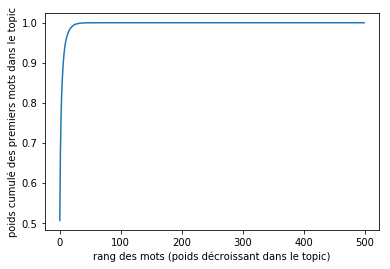

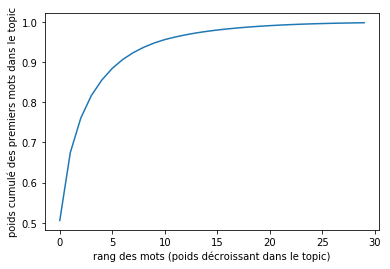

In [145]:
#tri des poids de chaque topic:
#initialisation:
coeffs_sorted = -np.sort(-topic_components.loc[0, range(num_top_words)])

#tri
for i in range(1,num_topics):
    if i in empty_topics:
        pass
    else:
        coeffs_sorted = np.vstack((coeffs_sorted, -np.sort(-topic_components.loc[i, range(num_top_words)])))

#calcul des poids cumulés et agrégation:
cum_weights = np.cumsum(coeffs_sorted, axis=1)
total_cum_weights = np.sum(cum_weights, axis=0)/cum_weights.shape[0]

#affichage des résultats:
# fig, ax = plt.subplots()
# ax.set_xscale('log')
plt.plot(range(num_top_words),total_cum_weights)
plt.xlabel('rang des mots (poids décroissant dans le topic)')
plt.ylabel('poids cumulé des premiers mots dans le topic')
plt.show()

#pour visualiser plus clairement, on se concentre sur les 100 mots principaux:
plt.plot(range(30),total_cum_weights[:30])
plt.xlabel('rang des mots (poids décroissant dans le topic)')
plt.ylabel('poids cumulé des premiers mots dans le topic')
plt.show()

Au vu de ce qui précède, il paraît raisonnable d'exclure de l'analyse tous les topics dont les 3 premiers mots représentent moins de 70% des coefficients:

In [157]:
num_top_words = 3
threshold = 0.7
indices  = [i for i in range(num_topics) if i not in empty_topics]
weights_top_words = pd.Series(cum_weights[:,num_top_words], index= indices)
#weights_top_words['total']=np.sum(weights_top_words, axis=1)
diffuse_topics = weights_top_words[weights_top_words<threshold].index
diffuse_topics

Int64Index([  3,   6,   8,  13,  19,  20,  26,  28,  39,  40,  41,  54,  55,
             58,  59,  60,  63,  68,  88, 134, 136, 141, 159, 167, 169, 170,
            174, 178, 179, 188, 193, 194],
           dtype='int64')

Voyons plus en détail ce que contiennent ces topics:

In [162]:
for t in diffuse_topics:
    print('topic_'+str(t)+':')
    print(topic_description[t])
    print('_'*30)
    print()

topic_3:
{'gouttiere': 8.886568795420281, 'accessoire': 1.8328622020982668, 'toiture': 1.74479174120813, 'bardage': 1.499492373875939, 'raccord': 1.213397030815059, 'revetement': 1.0543778404914077}
______________________________

topic_6:
{'ite': 4.277385475107397, 'revetement': 3.6291091148787484, 'facade': 3.0404588595844713, 'enduit': 2.579773214600891, 'platre': 2.1656692829830795, 'isolation': 2.130596174587145}
______________________________

topic_8:
{'evacuation': 4.091282944901453, 'eau': 3.5513503270073183, 'traitement': 1.6806458659962082, 'menuiserie': 1.5944740296372424, 'accessoire': 1.4842841590144218, 'materiaux': 1.3527192089629998}
______________________________

topic_13:
{'coller': 5.273283734641687, 'droguerie': 1.7875685028356556, 'face': 1.6428394951257048, 'mastic': 1.6140859930387983, 'peinturer': 1.5866654830325875, 'colle': 0.9901295182273578}
______________________________

topic_19:
{'scie': 2.21332352887237, 'portatif': 2.058936647607284, 'egoine': 2.0231

Voyons dans quelle mesure des topics caractéristiques des familles font partie de ces topics diffus:

In [284]:
topic_list = list(set(topics_by_fam['top_topic_1'])|set(topics_by_fam['top_topic_2']))
intersection = [t for t in diffuse_topics if t in topic_list]
print(intersection)

[6, 8, 13, 20, 28, 39, 40, 41, 58, 59, 60, 63, 88, 134, 136, 169, 170, 174, 178, 188, 193]


On voit ainsi qu'un certain nombre de topics diffus permettent de caractériser des familles.

Pour conclure cet examen des top topics, et disposer d'une base pour l'évaluation des changements de méthode testés par la suite, on entraîne un classifieur sur l'ensemble des données telles quelles, sans autre modifications en termes de préprocessing, constitution du dataset, ou sélection de topics :

In [166]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2, random_state = 548)
    
#entraînement d'un classifieur sur le train set et calcul du score
etc_ref = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_ref.fit(Xtrain,Ytrain)
score_ref = etc_ref.score(Xtest,Ytest)
print(score_ref)

0.9685230024213075


On constate un gain de performance modéré par rapport à un modèle similaire entraîné sur les données brutes issues du tf-idf. Voyons également quelles sont les performances lorsqu'on essaie de classifier les produits à partir de leurs deux topics principaux :

In [174]:
X_toptop = df_topics[['top_topic_1',
       'top_topic_1_relative_weight', 'top_topic_2',
       'top_topic_2_relative_weight']]

X_toptop_train, X_toptop_test, Ytrain, Ytest = train_test_split(X_toptop,Y,test_size=0.2, random_state = 548)

#entraînement d'un classifieur sur le train set et calcul du score
etc_toptop_ref = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_toptop_ref.fit(X_toptop_train,Ytrain)
score_toptop_ref = etc_toptop_ref.score(X_toptop_test,Ytest)
print(score_toptop_ref)

0.8999192897497982


On constate une baisse de précision. Note: le score obtenu en entraînant le modèle sur les deux premiers topics est supérieur à celui obtenu en ne gardant que le premier, les 3 premiers, ou les 4 premiers topics.

On va maintenant pouvoir évaluer l'impact des changements suivants sur la précision du modèle:
    - retrait du training set des produits dont les topics sont trop diffus, et dont l'appartenance à une catégorie donnée est ambiguë
    - retrait des topics dont le vocabulaire est trop diffus du jeu de features
    - retrait, au cours du preprocessing du corpus, des mots liés aux topics peu explicites

### Tests de plusieurs variantes en matière de préprocessing

#### 1- Retrait du training set des produits dont les topics sont trop diffus

Pour déterminer des seuils d'excplusion des produits en fonction des poids des topics principaux, on va d'abord tracer la courbe des poids cumulés moyens des n premiers topics sur l'ensemble du dataset labellisé :

In [194]:
cum_weights.shape[1]

200

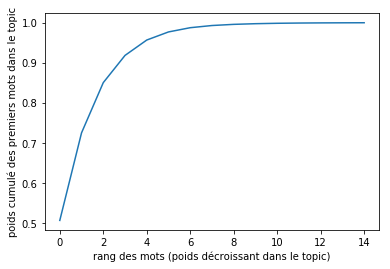

In [196]:
components = df_topics[col_names]

#tri des poids de chaque topic:
#initialisation:
coeffs_sorted = -np.sort(-components.loc[0])

#tri
for i in range(1,components.shape[0]):
    coeffs_sorted = np.vstack((coeffs_sorted, -np.sort(-components.iloc[i])))

#calcul des poids cumulés et agrégation:
cum_weights = np.cumsum(coeffs_sorted, axis=1)
total_cum_weights = np.sum(cum_weights, axis=0)/np.sum(cum_weights[:,num_topics-1])

#pour visualiser plus clairement, on se concentre sur les 100 mots principaux:
plt.plot(range(15),total_cum_weights[:15])
plt.xlabel('rang des topics (poids décroissant dans le produit)')
plt.ylabel('poids cumulé des premiers topics dans le produit')
plt.show()

In [197]:
total_cum_weights[:15]

array([0.50637601, 0.72491154, 0.850272  , 0.9182104 , 0.95660149,
       0.97681065, 0.9873772 , 0.99282412, 0.99571818, 0.99737766,
       0.99839446, 0.99901134, 0.99937825, 0.99960473, 0.9997544 ])

Compte tenu de ce qui précède, le seuil de 0.6 pour le poids cumulé des deux premiers topics d'un produit paraît raisonnable.

In [199]:
threshold = 0.6
df_topics['top1&2_weight'] = df_topics['top_topic_1_relative_weight']+df_topics['top_topic_2_relative_weight']
diffuse_products = df_topics[df_topics['top1&2_weight']<threshold].index
diffuse_products.shape

(1378,)

Voyons si, après retrait de ces produits, certaines familles conservent des effectifs suffisants:

In [204]:
recap = df_topics.drop(diffuse_products, axis=0)
recap = recap.groupby('Product_family_innoscape').count()
min(recap.productfamily_seller)

10

Pas besoin de retirer davantage de familles. On peut entraîner le classifieur :

In [210]:
X_red = X.drop(diffuse_products)
Y_red = Y.drop(diffuse_products)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_red,Y_red,test_size=0.2, random_state = 42)
    
#entraînement d'un classifieur sur le train set et calcul du score
etc_red = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_red.fit(Xtrain,Ytrain)
score_red = etc_red.score(Xtest,Ytest)
print(score_red)

0.9740394600207685


On observe une amélioration de la précision. Voyons ce qui se passe en ne travaillant que sur les deux 1ers topics:

In [211]:
X_toptop_red = X_toptop.drop(diffuse_products)

X_toptop_train, X_toptop_test, Ytrain, Ytest = train_test_split(X_toptop_red,Y_red,test_size=0.2, random_state = 548)

#entraînement d'un classifieur sur le train set et calcul du score
etc_toptop_red = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_toptop_red.fit(X_toptop_train,Ytrain)
score_toptop_red = etc_toptop_red.score(X_toptop_test,Ytest)
print(score_toptop_red)

0.9293873312564901


Le gain de précision est encore plus marqué.

Ces classifieurs sont-ils efficaces sur les produits qui ont été exclus du dataset?

In [391]:
Xval = df_topics.loc[diffuse_products,col_names]
Yval = df_topics.loc[diffuse_products,'Product_family_innoscape']
etc_red.score(Xval,Yval)

0.8570391872278664

In [394]:
Xval_red = X_toptop.loc[diffuse_products]
etc_toptop_red.score(Xval_red,Yval)

0.6262699564586357

#### 2- Retrait des topics diffus

In [221]:
frequent_topics2 = ['topic_'+str(t) for t in frequent_topics]
empty_topics2 = ['topic_'+str(t) for t in empty_topics]
diffuse_topics2 = ['topic_'+str(t) for t in diffuse_topics]

In [271]:
X_proj = X.drop(empty_topics2+diffuse_topics2, axis=1)
X_proj.shape

(6192, 142)

In [272]:
X_train, X_test, Ytrain, Ytest = train_test_split(X_proj,Y,test_size=0.2, random_state = 548)

#entraînement d'un classifieur sur le train set et calcul du score
etc_proj = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_proj.fit(X_train,Ytrain)
score_proj = etc_proj.score(X_test,Ytest)
print(score_proj)

0.9588377723970944


En ne conservant que les deux premiers topics:

In [307]:
df_topics2 = df_topics.copy().drop(['total_weights', 'top_topic_1', 'top_topic_1_relative_weight',
       'top_topic_2', 'top_topic_2_relative_weight', 'top_topic_3',
       'top_topic_3_relative_weight', 'top_topic_4',
       'top_topic_4_relative_weight', 'top1&2_weight'], axis=1)

In [320]:
col_names2 = [element for element in col_names if element not in empty_topics2+diffuse_topics2]
df_topics2 = df_topics2[col_names2]
total_weights = np.sum(df_topics2, axis=1)
df_topics2['total_weights'] = total_weights

In [345]:
#on réécrit légèrement les fonctions auxiliaires définies plus haut pour avoir les nouveaux top topics:
def get_top_topics2(row, cols_to_fetch, num_top_topics):
    top_topics_idx = np.argsort(-np.array(row[cols_to_fetch]))[:num_top_topics]
    top_topics = [int(element[6:]) for element in [cols_to_fetch[top_topics_idx[i]] for i in range(num_top_topics)]]
    top_topics_weights = row[['topic_'+str(element) for element in top_topics]].values
    return [top_topics,top_topics_weights]

In [351]:
df_topics2['top_top'] = df_topics2.apply(get_top_topics2, args=([col_names2,2]), axis=1)
df_topics2 = unpack_top_topics(df_topics2,'top_top','total_weights', 2)
df_topics2.drop('top_top', axis=1, inplace=True)
df_topics2.head()

topic_0  topic_1   topic_2   topic_4  topic_5  topic_7   topic_9  topic_10  \
0      0.0      0.0  0.005047  0.000000      0.0      0.0  0.000000       0.0   
3      0.0      0.0  0.005440  0.005141      0.0      0.0  0.000000       0.0   
4      0.0      0.0  0.000000  0.032532      0.0      0.0  0.040656       0.0   
6      0.0      0.0  0.008217  0.000000      0.0      0.0  0.000000       0.0   
7      0.0      0.0  0.006219  0.001678      0.0      0.0  0.000002       0.0   

   topic_11  topic_12  topic_14  topic_15  topic_16  topic_17  topic_18  \
0  0.000000       0.0       0.0       0.0  0.003488  0.000000       0.0   
3  0.025521       0.0       0.0       0.0  0.000000  0.000000       0.0   
4  0.000000       0.0       0.0       0.0  0.000000  0.000000       0.0   
6  0.000000       0.0       0.0       0.0  0.000000  0.041502       0.0   
7  0.065795       0.0       0.0       0.0  0.017514  0.000000       0.0   

   topic_21  topic_22  topic_23  topic_24  topic_25  topic_27  topic_29  \
0       0.0  0.000000       0.0       0.0       0.0       0.0  0.059302   
3       0.0  0.000000       0.0       0.0       0.0       0.0  0.062865   
4       0.0  0.000000       0.0       0.0       0.0       0.0  0.000000   
6       0.0  0.000036       0.0       0.0       0.0       0.0  0.000000   
7       0.0  0.000000       0.0       0.0       0.0       0.0  0.024126   

   topic_31  topic_32  topic_33  topic_34  topic_35  topic_36  topic_37  \
0       0.0       0.0       0.0       0.0  0.014522       0.0  0.000000   
3       0.0       0.0       0.0       0.0  0.027956       0.0  0.000000   
4       0.0       0.0       0.0       0.0  0.000000       0.0  0.035731   
6       0.0       0.0       0.0       0.0  0.000000       0.0  0.000000   
7       0.0       0.0       0.0       0.0  0.028535       0.0  0.000000   

   topic_38             ...               topic_166  topic_168  topic_171  \
0       0.0             ...                     0.0        0.0        0.0   
3       0.0             ...                     0.0        0.0        0.0   
4       0.0             ...                     0.0        0.0        0.0   
6       0.0             ...                     0.0        0.0        0.0   
7       0.0             ...                     0.0        0.0        0.0   

   topic_172  topic_173  topic_175  topic_176  topic_177  topic_180  \
0        0.0        0.0        0.0   0.000000        0.0        0.0   
3        0.0        0.0        0.0   0.000000        0.0        0.0   
4        0.0        0.0        0.0   0.000000        0.0        0.0   
6        0.0        0.0        0.0   0.000000        0.0        0.0   
7        0.0        0.0        0.0   0.010612        0.0        0.0   

   topic_181  topic_182  topic_183  topic_184  topic_185  topic_186  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
6        0.0        0.0        0.0        0.0        0.0        0.0   
7        0.0        0.0        0.0        0.0        0.0        0.0   

   topic_187  topic_189  topic_190  topic_191  topic_192  topic_195  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
6        0.0        0.0        0.0        0.0        0.0        0.0   
7        0.0        0.0        0.0        0.0        0.0        0.0   

   topic_196  topic_197  topic_198  topic_199  total_weights  top_topic_1  \
0        0.0        0.0        0.0        0.0       0.121218           29   
3        0.0        0.0        0.0        0.0       0.241810          132   
4        0.0        0.0        0.0        0.0       0.173393            9   
6        0.0        0.0        0.0        0.0       0.242287          146   
7        0.0        0.0        0.0

In [371]:
#retrait des produits dont seuls topics sont les topics diffus:
empty_products = df_topics2[df_topics2['total_weights']==0].index
empty_products.shape

(33,)

In [357]:
# entraînement d'un modèle sur les 2 premiers top topics
X = df_topics2[['top_topic_1',
                'top_topic_1_relative_weight',
                'top_topic_2',
                'top_topic_2_relative_weight']].drop(empty_products, axis=0)

Y = df_train_main_fams['Product_family_innoscape'].drop(empty_products)

X_train, X_test, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2, random_state = 548)

#entraînement d'un classifieur sur le train set et calcul du score
etc_toptop_proj = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_toptop_proj.fit(X_train,Ytrain)
score_toptop_proj = etc_toptop_proj.score(X_test,Ytest)
print(score_toptop_proj)

0.8741883116883117


On peut aussi essayer d'exclure du dataset les produits dont un des deux top topics est un topic diffus:

In [373]:
prod_to_delete_idx1 = [i for i in df_topics.index if df_topics.loc[i,'top_topic_1'] in diffuse_topics]
prod_to_delete_idx2 = [i for i in df_topics.index if df_topics.loc[i,'top_topic_2'] in diffuse_topics]
prod_to_delete = list(set(prod_to_delete_idx1)|set(prod_to_delete_idx2))
len(prod_to_delete)

2298

In [374]:
X = df_topics[col_names].drop(prod_to_delete, axis=0)
Y = df_topics['Product_family_innoscape'].drop(prod_to_delete)

X_train, X_test, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2, random_state = 548)

#entraînement d'un classifieur sur le train set et calcul du score
etc_clear = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_clear.fit(X_train,Ytrain)
score_clear = etc_clear.score(X_test,Ytest)
print(score_clear)

0.982028241335045


Conclusion : supprimer les coordonnées correspondant aux topics diffus des features dégrade la performance du modèle ; cependant, enlever les produits dont les top topics sont des topics diffus semble améliorer la performance du modèle.

### Retrait de davantage de mots lors du preprocessing

On va essayer de retirer davantage de mots au cours du preprocessing, en retirant les mots contenus dans les topics qui n'ont pas d'utilité pratique pour la classification.

Pour cela, on définit un topic peu utile comme un topic qui n'apparaît dans les 3 principaux topics d'aucune famille de produits.

On rappelle les principaux topics par famille:

In [379]:
topics_by_fam[['top_topic_1','top_topic_1_relative_weight',
               'top_topic_2','top_topic_2_relative_weight',
              'top_topic_3','top_topic_3_relative_weight']].head(50)

top_topic_1  \
Product_family_innoscape                                          
accessoires chauffe-eau                                      12   
accessoires couverture                                       95   
accessoires et consommables outillage électropo...           57   
accessoires pour nettoyeur haute pression                    39   
accessoires pour outillage motorisé                          39   
ampoules et leds                                            175   
aménagements décoratifs                                      72   
anti-mousse                                                 154   
arrosage                                                    193   
aspirateurs, souffleurs, broyeurs                           103   
aérateur et vmc                                              91   
bardage                                                       4   
barre de seuil et nez de marche                              59   
batterie et chargeur                                         17   
brise-vue, canisse, brande, grillage et brise vent           58   
chauffage                                                   129   
chauffe-eau gaz                                             121   
chauffe-eau électrique                                       12   
conduit et accessoires d'aération                            20   
contenants                                                  169   
couverture                                                   14   
disjoncteur, coupe-circuit et interrupteur diff...          180   
divers                                                      134   
divers oep                                                  187   
débroussailleuse et coupe-bordures                           52   
défonceuse et lamelleuse et rabot                           148   
gouttière, descente et accessoires                            8   
grillage avertisseur et gaine de protection                   5   
mastic, colle, étanchéité                                    13   
meuleuse et rainureuse                                       32   
motobineuses et motoculteurs                                170   
mousse expansive                                            154   
outil motorisé modulable                                     39   
outillage à main                                             22   
outils multifonctions                                        37   
peinture                                                      6   
perceuse, perforateur et visseuse filaire                    27   
perceuse, perforateur et visseuse sans fil                   10   
pince et tenaille                                           184   
pistolet à colle et agrafeuse                               182   
plinthe bois, plinthe mdf, plinthe pvc                       28   
ponceuse électrique                                          33   
poudre béton, chaux, ciment, enduit, mortier, r...          136   
protection jardin, paillage, tuteurs et accesso...           63   
scies électriques                                            71   
taille-haies                                                 48   
tondeuses electriques, thermiques et autoportée               7   
tournevis (cruciforme, aimanté, de précision…)              162   
tronçonneuse, scie et fendeur de bois                        41   
vidage, bonde et siphon                                     172   

                                                    top_topic_1_relative_weight  \
Product_family_innoscape                                                          
accessoires chauffe-eau                                                0.462712   
accessoires couverture                                                 0.097392   
accessoires et consommables outillage électropo...                     0.102334   
accessoires pour nettoyeur haute pression                              0.123307   
accessoires pour outillage motorisé                                  

In [413]:
useful_topics = list(set(topics_by_fam.top_topic_1)|set(topics_by_fam.top_topic_2)|set(topics_by_fam.top_topic_3))
useless_topics = [k for k in range(200) if k not in useful_topics]

Parmi ces topics, voyons combien ne sont pas déjà inclus dans les topics vides ou les topics diffus:

In [387]:
useless_topics2 = [t for t in useless_topics if not t in list(empty_topics)+list(diffuse_topics)]
len(useless_topics2)

80

Voyons à présent le contenu d'un de ces topics, et si le vocabulaire associé est présent dans des topics utiles:

In [388]:
print('topic_'+str(useless_topics2[0])+':')
print(topic_description[useless_topics2[0]])
print('_'*30)

topic_0:
{'tuile': 14.01206177768503, 'ardoise': 0.8329045081181543, 'couverture': 0.2057697428547121, 'huguenot': 0.14627942567271582, 'meridional': 0.06443755274021197, 'delta': 0.04887780043567778}
______________________________


Prenons le premier mot du topic et voyons s'il se retrouve dans d'autres topics:

In [400]:
#voc_reverse
#voc
w_idx = voc['tuile']
w_idx

469

On liste les topics dans lesquels ce mot est présent et les poids associés:

In [405]:
topics_raw[:,w_idx]
w_present = [i for i in range(num_topics) if topics_raw[:,w_idx][i]>0]
w_weight = topics_raw[:,w_idx][w_present]

In [409]:
w_weight

array([1.40120618e+01, 3.02278380e-01, 7.05594487e-01, 3.17381258e-01,
       1.30992552e+00, 2.85176393e-01, 6.79259965e-01, 3.30370359e-01,
       9.58984168e-01, 9.84363055e-01, 1.45371218e-01, 2.63051449e-01,
       9.54015491e-01, 6.10951533e-01, 3.88485896e-01, 6.86850293e-02,
       4.79375115e-01, 1.77672213e-01, 1.74024426e-01, 1.11942587e+00,
       4.77273633e-02, 2.06797572e-01, 3.28723648e-01, 1.61877370e-01,
       2.97774430e-02, 3.83672513e-01, 1.14936214e-02, 5.67904622e-01,
       2.01246370e-01, 4.85604231e-02, 7.41147741e-02, 9.79489918e-02,
       3.93786220e-01, 2.25897801e-01, 5.46582009e+00, 9.48644173e-02,
       3.48866315e-01, 1.17338012e-04, 4.34999243e-01, 2.23966824e-01])

On constate que le mot 'tuile' est présent dans un grand nombre de topics. Pour déterminer s'il est réellement important ou non, on va examiner s'il est présent dans des topics jugés importants, avec un poids significatif. On définit pour cela une fonction qui extrait les principaux mots des topics importants:

In [417]:
def get_important_words(uselful_topics, importance_threshold):
    important_words = []
    for t in useful_topics:
        significant_words = [k for k,v in topic_description[t].items() \
                             if topic_description[t][k]>=importance_threshold]
        important_words += list(significant_words)
    
    return sorted(list(set(important_words)))

On extrait ensuite les composantes des topics peu importants:

In [419]:
def get_unimportant_words(useless_topics, importance_threshold=0):
    important_words = []
    for t in useful_topics:
        significant_words = [k for k,v in topic_description[t].items() \
                             if topic_description[t][k]>=importance_threshold]
        important_words += list(significant_words)
    
    return sorted(list(set(important_words)))

Pour finir, on crée une liste de stop words complémentaires en comparant les deux listes:

In [429]:
important_words = set(get_important_words(useful_topics, 1))
unimportant_words = set(get_unimportant_words(useless_topics,0))
additional_stopwords = sorted(list(unimportant_words-important_words))
additional_stopwords

['adjuver',
 'alde',
 'alimentation',
 'aluminium',
 'autre',
 'ballon',
 'blanc',
 'branche',
 'broyeur',
 'chaine',
 'choc',
 'cloture',
 'cm³',
 'colle',
 'compatible',
 'consommable',
 'coupe',
 'cuivrer',
 'decoratif',
 'delta',
 'disque',
 'embout',
 'essence',
 'extraction',
 'fibre',
 'filet',
 'finition',
 'flux',
 'fond',
 'huguenot',
 'huile',
 'humidite',
 'hydrofuge',
 'impermeabilisation',
 'instantane',
 'isoler',
 'jeu',
 'jonc',
 'lanterner',
 'liquide',
 'machiner',
 'marseille',
 'mat',
 'max',
 'modeler',
 'naissance',
 'nettoyer',
 'one',
 'oneplus',
 'onglet',
 'ovation',
 'pate',
 'pistolet',
 'plancher',
 'plaque',
 'plinthe',
 'pointe',
 'polyurethane',
 'pot',
 'primaire',
 'rac',
 'recuperation',
 'reparation',
 'rive',
 'rouleau',
 'sanitaire',
 'scier',
 'seau',
 'securite',
 'sikaflex',
 'special',
 'steatite',
 'stratifier',
 'support',
 'surface',
 'tampon',
 'tuteur',
 'vegetal',
 'vinyle',
 'voir',
 'xmm',
 'zinc']

On peut à présent sauvegarder ces nouveaux stop words et reprendre toute la démarche:

In [476]:
#copie des données
df_seller_bis = df_seller.copy()
nulls = df_seller_bis[df_seller_bis['concat'].isnull()].index
df_seller_bis.drop(nulls, axis=0, inplace=True)

#suppression des nouveaux stopwords dans les champs texte:
def clean_stop_words(x,stop_word_list):
    return ' '.join(list(set(x.split(' '))-set(stop_word_list)))

df_seller_bis['concat'] = df_seller_bis['concat'].apply(clean_stop_words, args=([additional_stopwords]))

In [477]:
#conversion en tf-idf et embedding
num_top_words = 500
vectorizer = TfidfVectorizer(max_features = num_top_words)
tf_idf_total2 = sparse.csr_matrix(vectorizer.fit_transform(df_seller_bis['concat']))
nmf2 = NMF(n_components=200, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tf_idf_total2)

In [481]:
#préparation du train set et du test set
X2 = pd.DataFrame(nmf2.transform(tf_idf_total2.todense())).set_index(df_seller_bis.index.values).loc[df_train_main_fams.index]
X2.rename(columns=dict(zip(range(200),['topic_'+str(i) for i in range(200)])),inplace=True)
Y2 = df_train_main_fams['Product_family_innoscape']

In [482]:
#train_test_split et entraînement d'un modèle
X2train, X2test, Y2train, Y2test = train_test_split(X2,Y2,test_size=0.2, random_state = 548)
etc2 = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc2.fit(X2train,Y2train)
etc2.score(X2test, Y2test)

0.9507667473769169

In [499]:
#même démarche en ne prenant que les 2 top topics
num_topics = 200
num_top_topics = 4
X2['total_weights'] = np.sum(X2, axis=1)
X2 = X2[X2['total_weights']>0]
X2['top_top'] = X2.apply(get_top_topics, args=([200,num_top_topics]), axis=1)
X2 = unpack_top_topics(X2,'top_top','total_weights', num_top_topics)
X2.drop('top_top', axis=1, inplace=True)

In [500]:
X2_top = X2[['top_topic_1',
            'top_topic_1_relative_weight',
            'top_topic_2','top_topic_2_relative_weight']]

In [501]:
X2train, X2test, Y2train, Y2test = train_test_split(X2_top,Y2,test_size=0.2, random_state = 548)
etc2_top = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc2_top.fit(X2train,Y2train)
etc2_top.score(X2test, Y2test)

0.8611783696529459

Conclusion : Retirer davantage de stop words au moment du preprocessing ne semble pas améliorer la performance du modèle. Ce n'est pas forcément surprenant, dans la mesure où un grand nombre de mots du vocabulaire total ont été retirés lors de la transformation tf-idf.